# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
SEED = 2023

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
from collections import Counter

def entropy_log(objects):
  probabilities = np.array([ *Counter(objects).values() ]) / len(objects)
  return -np.sum(probabilities * np.log(probabilities))

print(f'''{entropy_log([ 1, 1, 1, 1, 1, 1, 1, 1, 2, 2 ]):.2f}''')

0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
from collections import Counter

def entropy_gini(objects):
  probabilities = np.array([ *Counter(objects).values() ]) / len(objects)
  return np.sum(probabilities * (1 - probabilities))

def criteria(left, right, entropy = entropy_gini):
  total = [ *left, *right ]
  return entropy(total) - len(left) / len(total) * entropy(left) - len(right) / len(total) * entropy(right)

print(f'''{criteria([ 1, 1, 1, 1, 1, 1, 1, 1 ], [ 2, 2 ]):.2f}''')

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
def predict_regression(values):
    return np.sum(values) / len(values)

predict_regression([ 1, 10, 5, 18, 100, 30, 50, 61, 84, 47 ])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def calculate_split_quality(threshold, feature_vector, target_vector, task, feature_type):
  match feature_type:
    case "real":
      mask = (feature_vector < threshold)
    case "categorical":
      mask = (feature_vector == threshold)
    case _:
      raise ValueError('Invalid feature_type')

  match task:
    case "regression":
      return criteria(target_vector[mask], target_vector[~mask], np.var)
    case "classification":
      return criteria(target_vector[mask], target_vector[~mask], entropy_gini)
    case _:
      raise ValueError('Invalid task')

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    match feature_type:
      case "real":
        values = np.sort(np.unique(feature_vector))
        if values.shape[0] == 1:
          values = np.concatenate([ values, values ])
        thresholds = (values[1:] + values[:-1]) / 2
      case "categorical":
        thresholds = np.unique(feature_vector)
      case _:
        raise ValueError('Invalid feature_type')

    qualities = np.vectorize(calculate_split_quality, excluded = [ 1, 2, 3, 4 ])(thresholds, feature_vector, target_vector, task, feature_type)
    bestQualityIndex = np.argmax(qualities)
    return (thresholds, qualities, thresholds[bestQualityIndex], qualities[bestQualityIndex])

In [ ]:
find_best_split(
    np.array([ 10, 11, 12, 13, 14, 15 ]),
    np.array([ 0, 0, 0, 1, 1, 2 ]),
    "classification",
    "real"
)

(array([10.5, 11.5, 12.5, 13.5, 14.5]),
 array([0.07777778, 0.19444444, 0.38888889, 0.19444444, 0.21111111]),
 12.5,
 0.38888888888888895)

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data = data["data"], columns = data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

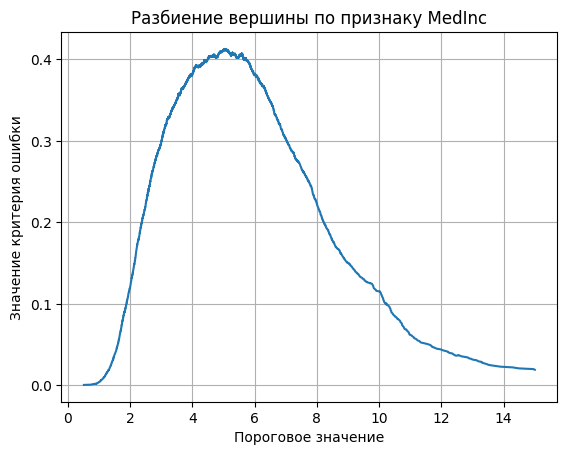

In [ ]:
result = find_best_split(X.MedInc, y, "regression", "real")
plt.grid()
plt.title("Разбиение вершины по признаку MedInc")
plt.xlabel("Пороговое значение")
plt.ylabel("Значение критерия ошибки")
plt.plot(result[0], result[1])
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
print(f'''MedInc < {result[2]}''')

MedInc < 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
from sklearn.preprocessing import normalize

class DecisionTree:
  def __init__(self, feature_types: Union[List[str], np.ndarray]) -> None:
    if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
        raise ValueError("There is unknown feature type")
    # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
    # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
    # левого детей (поддеревья для продолжения процедуры предсказания)
    self._tree = { }
    # типы признаков (категориальные или числовые)
    self._feature_types = feature_types
    # Переменная, если вы решите делать бонус
    self._feature_importances = { }

  def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict) -> None:
    # критерий останова
    if np.all(sub_y == sub_y[0]):
        node["type"] = "terminal"
        node["class"] = sub_y[0]
        return
    feature_best, threshold_best, gini_best, split = None, None, None, None
    for feature in range(sub_X.shape[1]):
        # подготавливаем признак для поиска оптимального порога
        feature_type = self._feature_types[feature]
        feature_vector = sub_X[:, feature]
        # ищем оптимальный порог
        _, _, threshold, gini = find_best_split(feature_vector, sub_y, 'classification', feature_type)
        if gini_best is None or gini > gini_best:
            feature_best, gini_best, threshold_best = feature, gini, threshold
            # split - маска на объекты, которые должны попасть в левое поддерево
            match feature_type:
              case "real":
                split = (feature_vector < threshold)
              case "categorical":
                split = (feature_vector == threshold)
              case _:
                raise ValueError('Invalid feature_type')
    # записываем полученные сплиты в атрибуты класса
    if feature_best is None:
        node["type"] = "terminal"
        node["class"] = Counter(sub_y).most_common(1)[0][0]
        return
    node["type"] = "nonterminal"
    node["feature_split"] = feature_best
    match self._feature_types[feature_best]:
      case "real":
        node["threshold"] = threshold_best
      case "categorical":
        node["category_split"] = threshold_best
      case _:
        raise ValueError('Invalid feature_type')
    node["left_child"], node["right_child"] = { }, { }
    self._fit_node(sub_X[split], sub_y[split], node["left_child"])
    self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

  def _predict_node(self, x: np.ndarray, node: dict) -> int:
    """
    Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
    предиката на объекте. Листовая вершина возвращает предсказание.
    :param x: np.array, элемент выборки
    :param node: dict, вершина дерева
    """
    if (node["type"] == "terminal"):
      # Лист - возвращаем ответ
      return node["class"]

    feature = node["feature_split"]
    match self._feature_types[feature]:
      case "real":
        # Разбиение по вещественному признаку
        return self._predict_node(x, node["left_child"] if (x[feature] < node["threshold"]) else node["right_child"])
      case "categorical":
        # Разбиение по категориальному признаку
        return self._predict_node(x, node["left_child"] if (x[feature] == node["category_split"]) else node["right_child"])
      case _:
        raise ValueError('Invalid feature_type')

  def fit(self, X: np.ndarray, y: np.ndarray) -> None:
    X = np.nan_to_num(X, nan = -1e18) # To correctly handle NaNs in regression
    self._fit_node(X, y, self._tree)

  def predict(self, X: np.ndarray) -> np.ndarray:
    X = np.nan_to_num(X, nan = -1e18) # To correctly handle NaNs in regression
    predicted = [ ]
    for x in X:
        predicted.append(self._predict_node(x, self._tree))
    return np.array(predicted)

  def feature_importances(self, X_train, y_train, X_test, y_test):
    self.fit(X_train, y_train) # Fit the model
    prediction = self.predict(X_test) # Get prediction
    best_score = f1_score(y_test, prediction) # Calculate accuracy for given data

    scores = [ ]
    for feature in range(X_train.shape[1]):
      X_test_copy = np.copy(X_test) # Copy the features array
      X_test_copy = np.transpose(X_test_copy) # Transpose the copied features array
      np.random.shuffle(X_test_copy[feature]) # Shuffle a row of the transposed features array (thus, a column of the initial features array)
      X_test_copy = np.transpose(X_test_copy) # Transpose the features array
      prediction = self.predict(X_test_copy) # Get a prediction for the new features
      scores.append(f1_score(y_test, prediction)) # Save the score
    return normalize([ best_score - scores ])[0] # Calculate and normalize the drops

Пропуски в данных в текущей реализации обрабатываются корректно. \
1. В случае наличия пропусков в значениях категориального признака, пропущенное значение фактически становится дополнительным классом ($-10^{18}$ или иное "пустое" значение), который обрабатывается наравне с остальными. На мой взгляд, это достаточно корректно: объекты, для которых значение признака неизвестно, имеет смысл рассматривать отдельно, что фактически и происходит.
2. Пропуски в значениях вещественных признаков заполняются очень маленьким значением ($-10^{18}$), что "заставит" дерево рассматривать их отдельно, аналогично случаю категориальных признаков. При поиске порога будет отдельно рассматриваться порог с очень маленьким значением, который будет фактически отделять объекты с пропущенным значением от остальных, и решать для них задачу отдельно. \

Следовательно, при таком подходе объекты с пропущенными значениями будут попадать в отдельные листья дерева, что позволит корректно решать для них задачу независимо от основной выборки, фактически не учитывая пропущенное значение.

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

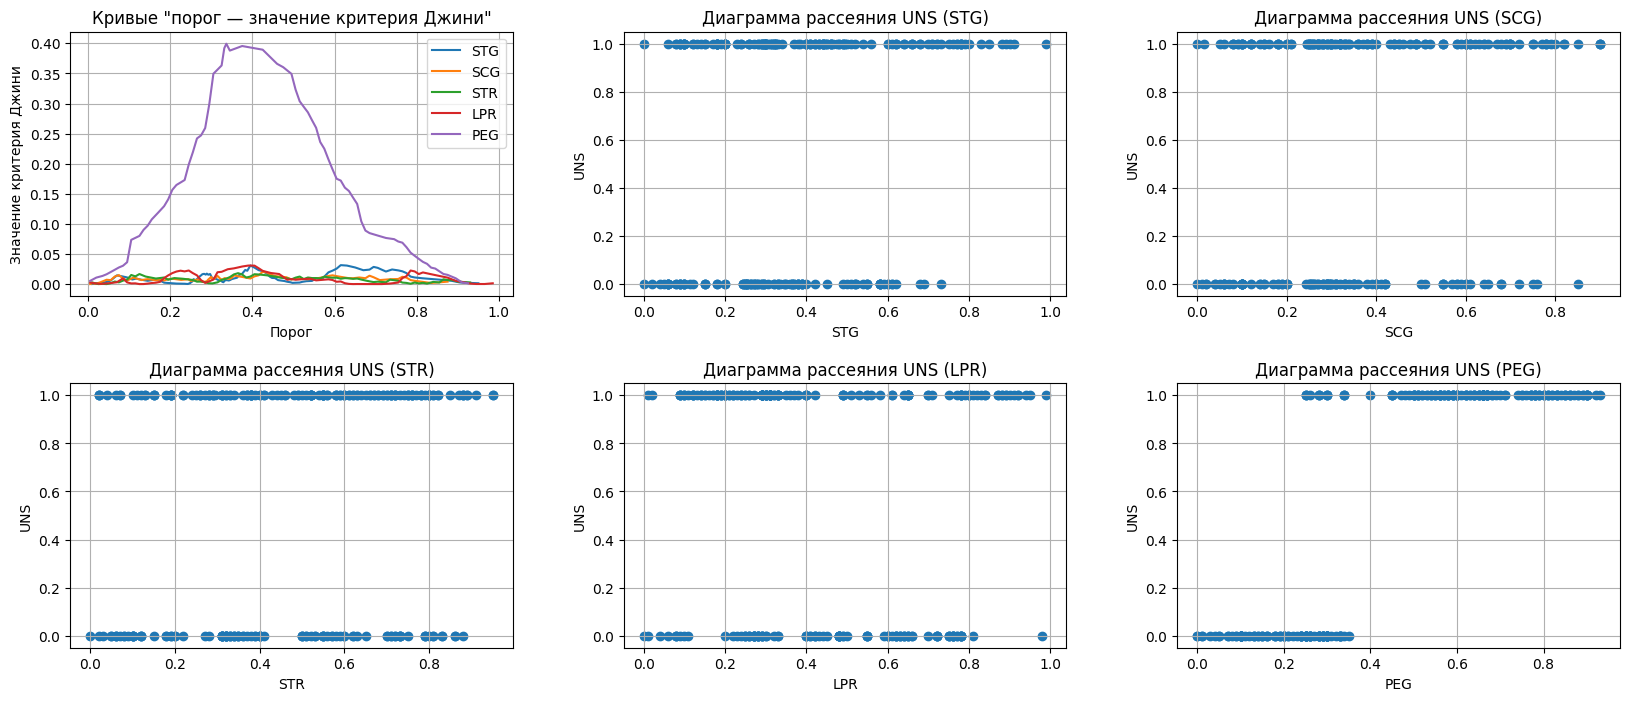

In [ ]:
students = pd.read_csv("students.csv")
features = [ "STG", "SCG", "STR", "LPR", "PEG" ]
figure, axes = plt.subplots(2, 3, figsize = (20, 8))
figure.subplots_adjust(hspace = 0.33, wspace = 0.25)

for feature in features:
  result = find_best_split(students[feature], students.UNS, "classification", "real")
  axes[0][0].plot(result[0], result[1], label = feature)
axes[0][0].grid()
axes[0][0].set_xlabel("Порог")
axes[0][0].set_ylabel("Значение критерия Джини")
axes[0][0].set_title('Кривые "порог — значение критерия Джини"')
axes[0][0].legend()

for i in range(0, len(features)):
  ax = axes[(i + 1) // 3][(i + 1) % 3]
  ax.grid()
  ax.set_ylabel("UNS")
  ax.set_xlabel(features[i])
  ax.set_title(f'''Диаграмма рассеяния UNS ({features[i]})''')
  ax.scatter(students[features[i]], students.UNS)

plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Деление выборки на два поддерева нужно производить по признаку PEG, так как для этого признака наиболее явно выделяется значение, при котором критерий информативности максимален. Для остальных признаков критерий информативности мал независимо от порога, а при приближении видно, что графики крайне изломаны и не содержат выделенного максимума. \
Этот результат согласуется с визуальной оценкой диаграмм рассеяния: по признаку PEG разделение классов видно наиболее явно. По признаку PEG классы разделяются почти идеально при пороге около 0.35, в то время как по остальным признакам разделение невозможно: объекты обоих классов равномерно распределены по большей части интервала значений признака. \
Таким образом, для "хороших" признаков, по которым выборка делится почти идеально, кривая значений критерия Джини должна выглядеть как график функции, которая монотонно возрастает до некоторого значения аргумента (порога), а затем монотонно убывает. При этом точка экстремума этой функции и является оптимальным значением величины порога. \
Как и было отмечено ранее, деление практически невозможно по признакам, для которых кривые сильно изломаны и не содержат явного максимума.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
data = pd.read_csv("agaricus-lepiota.data")
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [ ]:
from sklearn.preprocessing import LabelEncoder
data = data.apply(LabelEncoder().fit_transform)
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [ ]:
np.random.seed(SEED)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = [ "p" ]), data.p, test_size = 0.5)

model = DecisionTree([ "categorical" ] * 22)
model.fit(X_train.to_numpy(), y_train.to_numpy())

from sklearn.metrics import accuracy_score
accuracy_score(y_test, model.predict(X_test.to_numpy()))

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

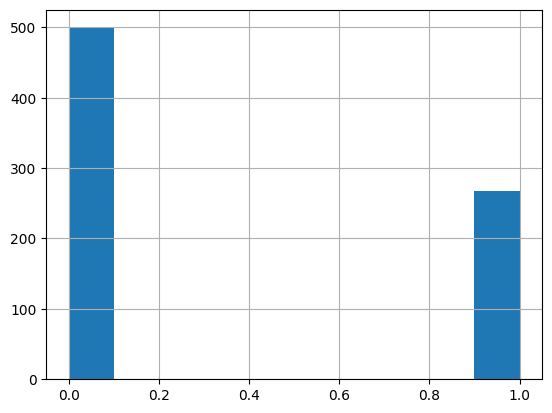

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X = data.drop(columns = [ 'Outcome' ])
y = data.Outcome
X_fulltrain, X_test, y_fulltrain, y_test = train_test_split(X, y, test_size = 0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_fulltrain, y_fulltrain, test_size = 0.3)
print(X_train.shape, X_valid.shape, X_test.shape)

(375, 8) (162, 8) (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
values = [ ]
for min_samples_leaf in range(1, 25):
  for max_depth in range(1, 25):
    values.append((max_depth, min_samples_leaf))
  values.append((None, min_samples_leaf))

from sklearn.metrics import f1_score
best_score = 0
best_value = ( None, 1 )
for value in values:
  model = DecisionTreeClassifier(max_depth = value[0], min_samples_leaf = value[1], random_state = SEED)
  model.fit(X_train, y_train)
  score = f1_score(y_valid, model.predict(X_valid))
  if (score > best_score):
    best_score = score
    best_value = value
print(best_score, best_value)

model = DecisionTreeClassifier(max_depth = best_value[0], min_samples_leaf = best_value[1], random_state = SEED)
model.fit(X_fulltrain, y_fulltrain)
prediction = model.predict(X_test)
print(f'''Accuracy: {accuracy_score(y_test, prediction)}''')
print(f'''Precision: {precision_score(y_test, prediction)}''')
print(f'''Recall: {recall_score(y_test, prediction)}''')
print(f'''AUC-ROC: {roc_auc_score(y_test, prediction)}''')

0.65 (5, 5)
Accuracy: 0.7402597402597403
Precision: 0.7551020408163265
Recall: 0.43529411764705883
AUC-ROC: 0.6765511684125706


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
model = BaggingClassifier(n_estimators = 50, random_state = SEED)
model.fit(X_fulltrain, y_fulltrain)
prediction = model.predict(X_test)
print(f'''Accuracy: {accuracy_score(y_test, prediction)}''')
print(f'''Precision: {precision_score(y_test, prediction)}''')
print(f'''Recall: {recall_score(y_test, prediction)}''')
print(f'''AUC-ROC: {roc_auc_score(y_test, prediction)}''')

Accuracy: 0.7316017316017316
Precision: 0.6666666666666666
Recall: 0.5411764705882353
AUC-ROC: 0.6918211120064465


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
np.random.seed(SEED)

values = [ ]
for min_samples_split in range(2, 10):
  for max_depth in range(1, 20):
    values.append((max_depth, min_samples_split))
  values.append((None, min_samples_split))

from sklearn.model_selection import cross_validate
best_score = 0
best_value = ( None, 2 )
for value in values:
  model = RandomForestClassifier(n_estimators = 50, max_depth = value[0], min_samples_split = value[1])
  score = np.average(cross_validate(model, X_fulltrain, y_fulltrain, scoring = 'f1')['test_score'])
  if (score > best_score):
    best_score = score
    best_value = value
print(best_score, best_value)

model = RandomForestClassifier(n_estimators = 50, max_depth = best_value[0], min_samples_split = best_value[1])
model.fit(X_fulltrain, y_fulltrain)
prediction = model.predict(X_test)
print(prediction)
print(f'''Accuracy: {accuracy_score(y_test, prediction)}''')
print(f'''Precision: {precision_score(y_test, prediction)}''')
print(f'''Recall: {recall_score(y_test, prediction)}''')
print(f'''AUC-ROC: {roc_auc_score(y_test, prediction)}''')

bestRandomForestModel = model

0.6751650339710041 (8, 4)
[0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1
 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0
 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 0]
Accuracy: 0.7402597402597403
Precision: 0.6923076923076923
Recall: 0.5294117647058824
AUC-ROC: 0.6962127316680097


**DecisionTreeClassifier**: \
Accuracy: 0.7402597402597403 \
Precision: 0.7551020408163265 \
Recall: 0.43529411764705883 \
AUC-ROC: 0.6765511684125706 \
**BaggingClassifier**: \
Accuracy: 0.7316017316017316 \
Precision: 0.6666666666666666 \
Recall: 0.5411764705882353 \
AUC-ROC: 0.6918211120064465 \
**RandomForestClassifier**: \
Accuracy: 0.7402597402597403 \
Precision: 0.6923076923076923 \
Recall: 0.5294117647058824 \
AUC-ROC: 0.6962127316680097 \
 \
Accuracy всех моделей приблизительно совпадают. Лишь BaggingClassifier показывает чуть более плохой результат. \
Precision максимален для DecisionTreeClassifier и минимален для BaggingClassifier. \
Recall, напротив, наиболее большой для BaggingClassifier и меньше остальных у DecisionTreeClassifier \
AUC-ROC же наиболее велик для RandomForestClassifier, а DecisionTreeClassifier показывает худший результат. \
 \
Таким образом, по совокупности метрик наиболее хорошо себя показала модель RandomForestClassifier, которая имеет наибольшие значения метрик Accuracy и AUC-ROC, а также сбалансированно-средние значения метрик Precision и Recall, что лучше, чем большое значение одной из метрик при маленькой величине другой, как у остальных рассмотренных моделей.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

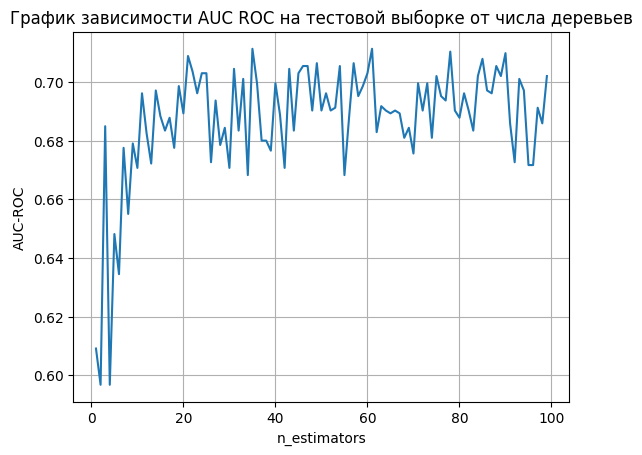

In [ ]:
np.random.seed(SEED)

estimators = [ ]
scores = [ ]
for n_estimators in range(1, 100):
  estimators.append(n_estimators)
  model = RandomForestClassifier(n_estimators = n_estimators, max_depth = best_value[0], min_samples_split = best_value[1])
  model.fit(X_fulltrain, y_fulltrain)
  scores.append(roc_auc_score(y_test, model.predict(X_test)))

plt.grid()
plt.xlabel("n_estimators")
plt.ylabel("AUC-ROC")
plt.title('График зависимости AUC ROC на тестовой выборке от числа деревьев')
plt.plot(estimators, scores)
plt.show()

График сильно изломан, что ожидаемо: размер тестовой выборки достаточно невелик. Тем не менее явно виден общий тренд - возрастание: с увеличением числа деревьев AUC-ROC увеличивается, хотя скорость роста уменьшается. Более того, с увеличением числа деревьев уменьшается "разброс" значений AUC-ROC при небольших изменениях числа деревьев: при n_estimators около 100 соседние значения AUC-ROC отличаются примерно на 0.2, в то время как при n_estimators близком к нулю, этот показатель превышает 0.8

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

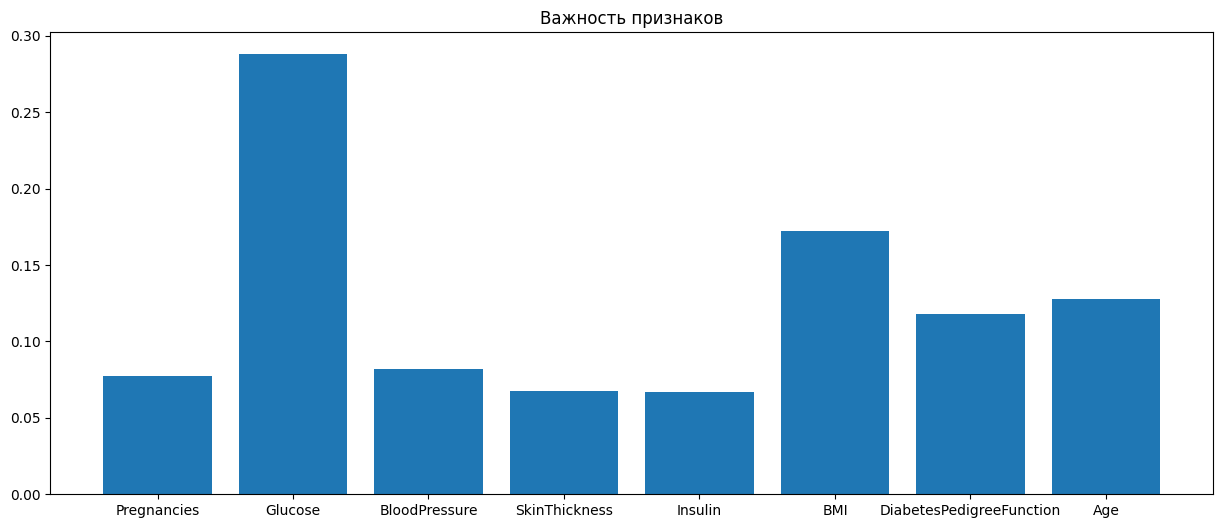

In [ ]:
plt.figure(figsize = (15, 6))
plt.title('Важность признаков')
plt.bar(data.drop(columns = "Outcome").columns, bestRandomForestModel.feature_importances_)
plt.show()

Самым важным для определения диабета оказался признак Glucose